# Data Processing
To combine all data sets into a single dataframe

In [15]:
# import libraries
import pandas as pd
import glob
from scipy.stats import linregress
import matplotlib.pyplot as plt

# select demand for victoria and sort in order of date
demand_vic = glob.glob("/Users/jiehni/monash/ads1002/ADS1002-project/Data/Demand/*_VIC*.csv")
demand_vic.sort()

# read demand data files and combine
df_list = [pd.read_csv(f) for f in demand_vic]
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print(combined_df.head())
else:
    print("No CSV files were loaded.")

  REGION    SETTLEMENTDATE  TOTALDEMAND    RRP PERIODTYPE
0   VIC1  2000/01/01 00:30   4419.03667   9.97      TRADE
1   VIC1  2000/01/01 01:00   4312.54000  12.58      TRADE
2   VIC1  2000/01/01 01:30   4599.70167  13.22      TRADE
3   VIC1  2000/01/01 02:00   4478.99000  12.90      TRADE
4   VIC1  2000/01/01 02:30   4228.81000  12.40      TRADE


In [11]:
# select datetime and drop invalid rows
combined_df['SETTLEMENTDATE'] = pd.to_datetime(combined_df['SETTLEMENTDATE'], errors='coerce')
combined_df.dropna(subset=['SETTLEMENTDATE'], inplace=True)

# sort by datetime and set as index
combined_df.sort_values(by='SETTLEMENTDATE', inplace=True)
combined_df.set_index('SETTLEMENTDATE', inplace=True)

demand_df = combined_df[['TOTALDEMAND']].copy()

In [8]:
# read weather data for melbourne victoria and combine
weather1_df = pd.read_csv("/Users/jiehni/monash/ads1002/ADS1002-project/Data/Temperature/HM01X_Data_086071_999999999743964.txt")
weather2_df = pd.read_csv("/Users/jiehni/monash/ads1002/ADS1002-project/Data/Temperature/HM01X_Data_086338_999999999743964.txt")
weather_df = pd.concat([weather1_df, weather2_df])
print(weather_df.columns)

# combine datetime into one variable with the correct format
weather_df['Datetime'] = pd.to_datetime({
    'year': weather_df['Year Month Day Hour Minutes in YYYY'],
    'month': weather_df['MM'],
    'day': weather_df['DD'],
    'hour': weather_df['HH24'],
    'minute': weather_df['MI format in Local time']
})

# drop invalid datetime rows
weather_df = weather_df.dropna(subset=['Datetime'])
weather_df = weather_df.set_index('Datetime')

/var/folders/0d/qf_dfhwn3vjd4fvry35670240000gn/T/ipykernel_23848/79151554.py:2: DtypeWarning: Columns (12,14,18,20,22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  weather1_df = pd.read_csv("/Users/jiehni/monash/ads1002/ADS1002-project/Data/Temperature/HM01X_Data_086071_999999999743964.txt")
/var/folders/0d/qf_dfhwn3vjd4fvry35670240000gn/T/ipykernel_23848/79151554.py:3: DtypeWarning: Columns (12,16,22,24,26,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  weather2_df = pd.read_csv("/Users/jiehni/monash/ads1002/ADS1002-project/Data/Temperature/HM01X_Data_086338_999999999743964.txt")


Index(['hm', 'Station Number', 'Year Month Day Hour Minutes in YYYY', 'MM',
       'DD', 'HH24', 'MI format in Local time',
       'Year Month Day Hour Minutes in YYYY.1', 'MM.1', 'DD.1', 'HH24.1',
       'MI format in Local standard time',
       'Precipitation since 9am local time in mm',
       'Quality of precipitation since 9am local time',
       'Air Temperature in degrees C', 'Quality of air temperature',
       'Wet bulb temperature in degrees C', 'Quality of Wet bulb temperature',
       'Dew point temperature in degrees C',
       'Quality of dew point temperature', 'Relative humidity in percentage %',
       'Quality of relative humidity', 'Wind speed in km/h',
       'Wind speed quality', 'Wind direction in degrees true',
       'Wind direction quality',
       'Speed of maximum windgust in last 10 minutes in  km/h',
       'Quality of speed of maximum windgust in last 10 minutes',
       'Mean sea level pressure in hPa', 'Quality of mean sea level pressure',
       'Stati

In [12]:
# select temperature column and rename
weather_clean = weather_df[['Air Temperature in degrees C']].copy()
weather_clean.columns = ['Temperature']
weather_clean['Temperature'] = pd.to_numeric(weather_clean['Temperature'], errors='coerce')

In [13]:
# merge demand and temperature data
merged_df = pd.merge(
    demand_df,
    weather_clean,
    left_index=True,
    right_index=True,
    how='inner'
)

print(merged_df.head())


                     TOTALDEMAND  Temperature
SETTLEMENTDATE                               
2000-01-01 01:30:00   4599.70167         13.7
2000-01-01 02:00:00   4478.99000         13.6
2000-01-01 02:30:00   4228.81000         13.3
2000-01-01 03:00:00   3989.10000         14.1
2000-01-01 03:30:00   3783.93167         13.5


In [23]:
# drop invalid rows/values
subset = merged_df[['Temperature', 'TOTALDEMAND']].dropna()

# perform linear regression
slope, intercept, r, p, se = linregress(subset['Temperature'], subset['TOTALDEMAND'])
print(f"Slope: {slope:.2f}, R²: {r**2:.3f}")


Slope: 12.55, R²: 0.010


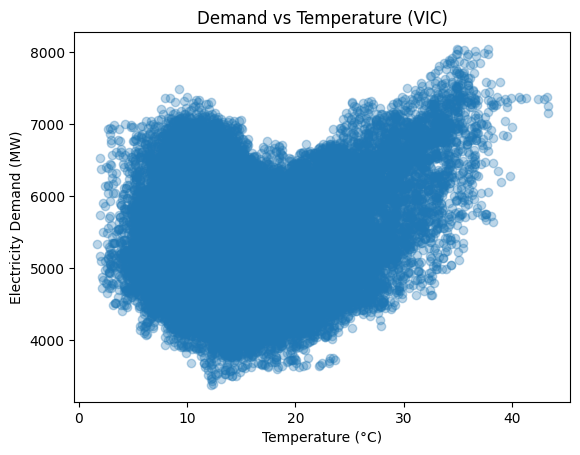

In [19]:
# create scatter plot of demand vs temperature in victoria
plt.scatter(merged_df['Temperature'], merged_df['TOTALDEMAND'], alpha=0.3)
plt.title('Demand vs Temperature (VIC)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Demand (MW)')
plt.show()
